# Sequence-to-Sequence RNN Models: Translation Task

In [1]:
!pip install torchtext==0.15.1
!pip install torch==2.0.0
!pip install spacy==3.7.2
!pip install torchdata==0.6.0
!pip install portalocker>=2.0.0 #2.7.0
!pip install nltk==3.8.1
!pip install -U matplotlib

!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchdata.datapipes.iter import IterableWrapper, Mapper
import torchtext
from torchtext.vocab import build_vocab_from_iterator
from nltk.translate.bleu_score import sentence_bleu
import torch
import torch.nn as nn
import torch.optim as optim


import numpy as np
import random
import math
import time
from tqdm import tqdm
import matplotlib.pyplot as plt


# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# Background
Sequence-to-sequence (Seq2seq) models have revolutionized various natural language processing (NLP) tasks, such as machine translation, text summarization, and chatbots. These models employ Recurrent Neural Networks (RNNs) to process variable-length input sequences and generate variable-length output sequences.

# History of sequence-to-sequence models
Sequence-to-sequence models were introduced as an extension of traditional feedforward neural networks. Researchers realized the need for models that could handle variable-length input and output sequences, such as machine translation. The pioneering work of Sutskever et al. (2014) introduced the use of RNNs for seq2seq models.

Here are some main objectives of seq2seq models:

Translation: Translating a sequence from one domain to another (e.g., English to French).
Question answering: Generating a natural language response given an input sentence (e.g., chatbots).
Summarization: Summarizing a long document into a shorter sequence of sentences. And many more applications that involve sequence generation.

### **Introduction to RNNs (Recurrent Neural Networks)**  

RNNs are a type of neural network designed to process **sequential data** (like text, speech, or time-series data). Unlike traditional neural networks, RNNs **remember past information** and use it to make decisions in the present. This memory comes from a loop in their architecture, allowing information to pass from one step to the next.  

### **How RNNs Work?**  
At each time step, RNNs take an **input** and update their **hidden state** using both the **current input** and the **previous hidden state**. Mathematically, it is represented as:  

\[
h_t = \sigma(W_x \cdot x_t + W_h \cdot h_{t-1} + b)
\]

Where:  
- \( h_t \) = current hidden state (memory)  
- \( x_t \) = current input  
- \( h_{t-1} \) = previous hidden state  
- \( W_x, W_h \) = weight matrices  
- \( b \) = bias term  
- \( \sigma \) = activation function (like tanh or sigmoid)  

If the model needs to generate an **output** (like predicting the next word in a sentence), we use:  

\[
y_t = \text{softmax}(W_o \cdot h_t + b_o)
\]

Where \( W_o \) and \( b_o \) are output layer parameters.  

### **Why Use RNNs?**  
- They are useful for **speech recognition**, **text generation**, **sentiment analysis**, and **time-series forecasting**.  
- Unlike normal neural networks, RNNs can understand the **order of words** in a sentence.  

### **Challenges with RNNs**  
One big problem with RNNs is the **vanishing gradient problem**—which means they struggle with very long sequences. To fix this, we use **LSTM (Long Short-Term Memory)** and **GRU (Gated Recurrent Unit)** networks, which handle long-term dependencies better.  

Let me know if you need an even simpler explanation! 😊

In [3]:
 W_xh=torch.tensor(-10.0)
 W_hh=torch.tensor(10.0)
 b_h=torch.tensor(0.0)
 x_t=1
 h_prev=torch.tensor(-1)

In [4]:
X=[1,1,-1,-1,1,1]

In [5]:
H=[-1,-1,0,1,0,-1]

In [6]:
# Initialize an empty list to store the predicted state values
H_hat = []
# Loop through each data point in the input sequence X
t=1
for x in X:
    # Assign the current data point to x_t
    print("t=",t)
    x_t = x
    # Print the value of the previous state (h at time t-1)
    print("h_t-1", h_prev.item())

    # Compute the current state (h at time t) using the RNN formula with tanh activation
    h_t = torch.tanh(x_t * W_xh + h_prev * W_hh + b_h)

    # Update h_prev to the current state value for the next iteration
    h_prev = h_t

    # Print the current input value (x at time t)
    print("x_t", x_t)

    # Print the computed state value (h at time t)
    print("h_t", h_t.item())
    print("\n")

    # Append the current state value to the H_hat list after converting it to integer
    H_hat.append(int(h_t.item()))
    t+=1


t= 1
h_t-1 -1
x_t 1
h_t -1.0


t= 2
h_t-1 -1.0
x_t 1
h_t -1.0


t= 3
h_t-1 -1.0
x_t -1
h_t 0.0


t= 4
h_t-1 0.0
x_t -1
h_t 1.0


t= 5
h_t-1 1.0
x_t 1
h_t 0.0


t= 6
h_t-1 0.0
x_t 1
h_t -1.0




In [7]:
H_hat

[-1, -1, 0, 1, 0, -1]

In [8]:
H

[-1, -1, 0, 1, 0, -1]

In [9]:
class Encoder(nn.Module):
    def __init__(self, vocab_len, emb_dim, hid_dim, n_layers, dropout_prob):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(vocab_len, emb_dim)

        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_batch):
        #input_batch = [src len, batch size]
        embed = self.dropout(self.embedding(input_batch))
        embed = embed.to(device)
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        outputs, (hidden, cell) = self.lstm(embed)

        return hidden, cell


In [10]:
vocab_len = 8
emb_dim = 10
hid_dim=8
n_layers=1
dropout_prob=0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_t = Encoder(vocab_len, emb_dim, hid_dim, n_layers, dropout_prob).to(device)

In [11]:
src_batch = torch.tensor([[0,3,4,2,1]])
# you need to transpose the input tensor as the encoder LSTM is in Sequence_first mode by default

src_batch = src_batch.t().to(device)

print("Shape of input(src) tensor:", src_batch.shape)
hidden_t , cell_t = encoder_t(src_batch)
print("Hidden tensor from encoder:",hidden_t ,"\nCell tensor from encoder:", cell_t)

Shape of input(src) tensor: torch.Size([5, 1])
Hidden tensor from encoder: tensor([[[ 0.0609, -0.2640, -0.1649,  0.4527,  0.4033, -0.1157, -0.1677,
          -0.0798]]], device='cuda:0', grad_fn=<CudnnRnnBackward0>) 
Cell tensor from encoder: tensor([[[ 0.2354, -0.5797, -0.3416,  0.5700,  0.4955, -0.1840, -0.2089,
          -0.3353]]], device='cuda:0', grad_fn=<CudnnRnnBackward0>)


In [12]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers


        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):


        #input = [batch size]

        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]

        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]

        input = input.unsqueeze(0)
        #input = [1, batch size]

        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]

        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]

        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        prediction_logit = self.fc_out(output.squeeze(0))
        prediction = self.softmax(prediction_logit)
        #prediction = [batch size, output dim]


        return prediction, hidden, cell

In [13]:
output_dim = 6
emb_dim=10
hid_dim = 8
n_layers=1
dropout=0.5
decoder_t = Decoder(output_dim, emb_dim, hid_dim, n_layers, dropout).to(device)

# Encoder-decoder connection


In [14]:
#  Step 1: Teacher Forcing Ratio
teacher_forcing_ratio = 0.5

#  Step 2: Target Tensor (Ground Truth)
trg = torch.tensor([[0],[2],[3],[5],[1]]).to(device)

# Step 3: Output Tensor Initialization
batch_size = trg.shape[1]
trg_len = trg.shape[0]
trg_decode_size = decoder_t.output_dim


#tensor to store decoder output
outputs_t = torch.zeros(trg_len, batch_size, trg_decode_size).to(device)

#send to device
hidden_state = hidden_t.to(device)
cell_t = cell_t.to(device)

# first input to the decoder is the <bos> tokens

# Step 4: First Input for Decoder
input = trg[0,:]

# Step 5: Loop Through Target Length

for t in range(1, trg_len):
    # Step 6: Decoder Forward Pass
    output_t, hidden_t, cell_t = decoder_t(input, hidden_t, cell_t)
    # Step 7: Store the Prediction
    outputs_t[t] = output_t
    #  8: Decide Teacher Forcing
    teacher_force = random.random() < teacher_forcing_ratio
    # Step 9: Choose Next Input
    top1 = output_t.argmax(1)
    input = trg[t] if teacher_force else top1
# Final Output
print(outputs_t, outputs_t.shape)

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[-1.8252, -1.7739, -1.6924, -1.7417, -1.8515, -1.8784]],

        [[-1.6975, -1.6951, -2.0238, -1.8077, -1.8257, -1.7373]],

        [[-1.7058, -1.6692, -1.9671, -1.8658, -1.8575, -1.7188]],

        [[-1.7642, -1.8123, -1.9010, -1.7593, -1.7983, -1.7246]]],
       device='cuda:0', grad_fn=<CopySlices>) torch.Size([5, 1, 6])


In [15]:
# need to get the argmax from the second dimension as **outputs** is an array of **output** tensors
pred_tokens = outputs_t.argmax(2)
print(pred_tokens)

tensor([[0],
        [2],
        [1],
        [1],
        [5]], device='cuda:0')


# Sequence-to-sequence model implementation in PyTorch
Let's connect encoder and decoder components to create the seq2seq model.

In [16]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device,trg_vocab):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.trg_vocab = trg_vocab

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 you use ground-truth inputs 75% of the time


        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        hidden = hidden.to(device)
        cell = cell.to(device)


        #first input to the decoder is the <bos> tokens
        input = trg[0,:]

        for t in range(1, trg_len):

            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output

            #decide if you are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio

            #get the highest predicted token from your predictions
            top1 = output.argmax(1)


            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            #input = trg[t] if teacher_force else top1
            input = trg[t] if teacher_force else top1


        return outputs

# Training model in PyTorch

In [17]:
def train(model, iterator, optimizer, criterion, clip):

    model.train()

    epoch_loss = 0

    # Wrap iterator with tqdm for progress logging
    train_iterator = tqdm(iterator, desc="Training", leave=False)

    for i, (src,trg) in enumerate(iterator):

        src = src.to(device)
        trg = trg.to(device)
        optimizer.zero_grad()

        output = model(src, trg)

        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]

        output_dim = output.shape[-1]

        output = output[1:].view(-1, output_dim)

        trg = trg[1:].contiguous().view(-1)

        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        # Update tqdm progress bar with the current loss
        train_iterator.set_postfix(loss=loss.item())

        epoch_loss += loss.item()


    return epoch_loss / len(list(iterator))

## Evaluating model in PyTorch

In [18]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    # Wrap iterator with tqdm for progress logging
    valid_iterator = tqdm(iterator, desc="Training", leave=False)

    with torch.no_grad():

        for i, (src,trg) in enumerate(iterator):

            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]

            output = output[1:].view(-1, output_dim)

            trg = trg[1:].contiguous().view(-1)


            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            # Update tqdm progress bar with the current loss
            valid_iterator.set_postfix(loss=loss.item())

            epoch_loss += loss.item()

    return epoch_loss / len(list(iterator))

# Data preprocessing

In [19]:
!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/Multi30K_de_en_dataloader.py'

--2025-02-05 04:49:25--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/Multi30K_de_en_dataloader.py
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4890 (4.8K) [application/x-python]
Saving to: ‘Multi30K_de_en_dataloader.py’

Multi30K_de_en_data 100%[===================>]   4.78K  --.-KB/s    in 0s      

2025-02-05 04:49:26 (2.22 GB/s) - ‘Multi30K_de_en_dataloader.py’ saved [4890/4890]



In [20]:
%run Multi30K_de_en_dataloader.py

In [21]:
train_dataloader, valid_dataloader = get_translation_dataloaders(batch_size = 4)#,flip=True)

In [22]:
src, trg = next(iter(train_dataloader))
src,trg

(tensor([[    2,     2,     2,     2],
         [    3,  5510,  5510, 12642],
         [    1,     3,     3,     8],
         [    1,     1,     1,  1701],
         [    1,     1,     1,     3]], device='cuda:0'),
 tensor([[   2,    2,    2,    2],
         [   3, 6650,  216,    6],
         [   1, 4623,  110, 3398],
         [   1,  259, 3913,  202],
         [   1,  172, 1650,  109],
         [   1, 9953, 3823,   37],
         [   1,  115,   71,    3],
         [   1,  692, 2808,    1],
         [   1, 3428, 2187,    1],
         [   1,    5,    5,    1],
         [   1,    3,    3,    1]], device='cuda:0'))

In [23]:
data_itr = iter(train_dataloader)
# moving forward in the dataset to reach sequences of longer length for illustration purpose. (Remember the dataset is sorted on sequence len for optimal padding)
for n in range(1000):
    german, english= next(data_itr)

for n in range(3):
    german, english=next(data_itr)
    german=german.T
    english=english.T
    print("________________")
    print("german")
    for g in german:
        print(index_to_german(g))
    print("________________")
    print("english")
    for e in english:
        print(index_to_eng(e))


________________
german
<bos> Personen mit schwarzen Hüten in der Innenstadt . <eos>
<bos> Eine Gruppe Menschen protestiert in einer Stadt . <eos>
<bos> Eine Gruppe teilt ihre politischen Ansichten mit . <eos>
<bos> Mehrere Personen sitzen an einem felsigen Strand . <eos>
________________
english
<bos> People in black hats gathered together downtown . <eos> <pad> <pad> <pad>
<bos> A group of people protesting in a city . <eos> <pad> <pad>
<bos> A group is letting their political opinion be known . <eos> <pad>
<bos> A group of people are sitting on a rocky beach . <eos>
________________
german
<bos> Zwei sitzende Personen mit Hüten und Sonnenbrillen . <eos>
<bos> Ein kleiner Junge mit Hut beim Angeln . <eos>
<bos> Diese zwei Frauen haben Spaß im Giorgio's . <eos>
<bos> Zwei kleine Kinder schlafen auf dem Sofa . <eos>
________________
english
<bos> Two people sitting in hats and shades . <eos> <pad> <pad> <pad>
<bos> A young boy in a hat is fishing by himself . <eos>
<bos> These two wome

# Training the model
Initializations

In [24]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Training
Now, define an instance of the model:

- `enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)`: This line creates an instance of the `Encoder` class, which represents the encoder component of the Seq2Seq model. The `Encoder` class takes the input dimension, embedding dimension, hidden dimension, number of layers, and dropout probability as arguments.

- `dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)`: This line creates an instance of the `Decoder` class, which represents the decoder component of the Seq2Seq model. The `Decoder` class takes the output dimension, embedding dimension, hidden dimension, number of layers, and dropout probability as arguments.

- `model = Seq2Seq(enc, dec, device,trg_vocab = vocab_transform['en']).to(device)`: This line creates an instance of the `Seq2Seq` class, which represents the entire Seq2Seq model. The `Seq2Seq` class takes the encoder, decoder, and device (e.g., CPU or GPU) as arguments. It combines the encoder and decoder to form the complete Seq2Seq architecture.


In [25]:
INPUT_DIM = len(vocab_transform['de'])
OUTPUT_DIM = len(vocab_transform['en'])
ENC_EMB_DIM = 128 #256
DEC_EMB_DIM = 128 #256
HID_DIM = 256 #512
N_LAYERS = 1 #2
ENC_DROPOUT = 0.3 #0.5
DEC_DROPOUT = 0.3 #0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device,trg_vocab = vocab_transform['en']).to(device)

`def init_weights(m)`defines a function named `init_weights` that takes a module `m` as input. The purpose of this function is to initialize the weights of the neural network module.

The next line `for name, param in m.named_parameters():` starts a loop that iterates over the named parameters of the module `m`. Each parameter is accessed as `param` and its corresponding name is accessed as `name`.

`nn.init.uniform_(param.data, -0.08, 0.08)`initializes the parameter's data with values drawn from a uniform distribution between `-0.08` and `0.08`. The `nn.init.uniform_` function is provided by the PyTorch library and is used to initialize the weights of neural network parameters.

Finally, `model.apply(init_weights)` applies the `init_weights` function to the `model` instance. This ensures that the weights of all the parameters in the model are initialized using the specified uniform distribution.


In [26]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(19214, 128)
    (lstm): LSTM(128, 256, dropout=0.3)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10837, 128)
    (lstm): LSTM(128, 256, dropout=0.3)
    (fc_out): Linear(in_features=256, out_features=10837, bias=True)
    (softmax): LogSoftmax(dim=1)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (trg_vocab): Vocab()
)

This code defines a function `count_parameters` that counts the number of trainable parameters in a given model. It then prints the count of trainable parameters in a formatted string.


In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,422,165 trainable parameters


The following cell sets up the optimizer and loss function for training the model.

1. `optimizer = optim.Adam(model.parameters())`: This line creates an instance of the Adam optimizer and passes the model's parameters (`model.parameters()`) as the parameters to be optimized. The Adam optimizer is a popular optimization algorithm commonly used for training deep neural networks. It adjusts the model's parameters based on the gradients computed during backpropagation to minimize the loss function.

2. `PAD_IDX = vocab_transform['en'].get_stoi()['<pad>']`: This line retrieves the index of the `<pad>` token in the target vocabulary.

3. `criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)`: This line creates an instance of the CrossEntropyLoss criterion. The CrossEntropyLoss is a commonly used loss function for multi-class classification tasks. In this case, it is used for training the model to predict the next word in the translated sequence. The `ignore_index` parameter is set to `PAD_IDX`, which indicates that the loss should be ignored for any predictions where the target is the padding token. This is useful to exclude padding tokens from contributing to the loss during training.


In [28]:
optimizer = optim.Adam(model.parameters())

PAD_IDX = vocab_transform['en'].get_stoi()['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [29]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
torch.cuda.empty_cache()

N_EPOCHS = 3 #run the training for at least 5 epochs
CLIP = 1

best_valid_loss = float('inf')
best_train_loss = float('inf')
train_losses = []
valid_losses = []

train_PPLs = []
valid_PPLs = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
    train_ppl = math.exp(train_loss)
    valid_loss = evaluate(model, valid_dataloader, criterion)
    valid_ppl = math.exp(valid_loss)


    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    if valid_loss < best_valid_loss:

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'RNN-TR-model.pt')

    train_losses.append(train_loss)
    train_PPLs.append(train_ppl)
    valid_losses.append(valid_loss)
    valid_PPLs.append(valid_ppl)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_ppl:7.3f}')


Epoch: 01 | Time: 4m 1s
	Train Loss: 4.384 | Train PPL:  80.144
	 Val. Loss: 5.305 |  Val. PPL: 201.399


Epoch: 02 | Time: 4m 3s
	Train Loss: 3.647 | Train PPL:  38.346
	 Val. Loss: 4.773 |  Val. PPL: 118.317


Epoch: 03 | Time: 4m 7s
	Train Loss: 3.241 | Train PPL:  25.552
	 Val. Loss: 4.422 |  Val. PPL:  83.259


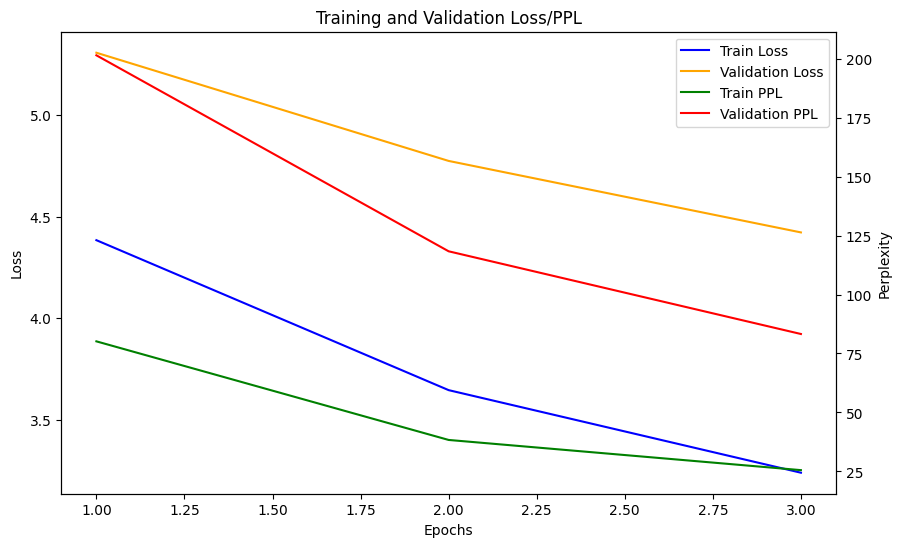

In [31]:
import matplotlib.pyplot as plt



# Create a list of epoch numbers
epochs = [epoch+1 for epoch in range(N_EPOCHS)]

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plotting the training and validation loss
ax1.plot(epochs, train_losses, label='Train Loss', color='blue')
ax1.plot(epochs, valid_losses, label='Validation Loss', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss/PPL')

# Plotting the training and validation perplexity
ax2.plot(epochs, train_PPLs, label='Train PPL', color='green')
ax2.plot(epochs, valid_PPLs, label='Validation PPL', color='red')
ax2.set_ylabel('Perplexity')

# Adjust the y-axis scaling for PPL plot
ax2.set_ylim(bottom=min(min(train_PPLs), min(valid_PPLs)) - 10, top=max(max(train_PPLs), max(valid_PPLs)) + 10)

# Set the legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper right')


# Show the plot
plt.show()


In [32]:
# !wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/RNN-TR-model.pt'
# model.load_state_dict(torch.load('RNN-TR-model.pt',map_location=torch.device('cpu')))

# Model inference

In [33]:
import torch.nn.functional as F

def generate_translation(model, src_sentence, src_vocab, trg_vocab, max_len=50):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        src_tensor = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1).to(device)

        # Pass the source tensor through the encoder
        hidden, cell = model.encoder(src_tensor)

        # Create a tensor to store the generated translation
        # get_stoi() maps tokens to indices
        trg_indexes = [trg_vocab.get_stoi()['<bos>']]  # Start with <bos> token

        # Convert the initial token to a PyTorch tensor
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(1)  # Add batch dimension

        # Move the tensor to the same device as the model
        trg_tensor = trg_tensor.to(model.device)


        # Generate the translation
        for _ in range(max_len):

            # Pass the target tensor and the previous hidden and cell states through the decoder
            output, hidden, cell = model.decoder(trg_tensor[-1], hidden, cell)

            # Get the predicted next token
            pred_token = output.argmax(1)[-1].item()

            # Append the predicted token to the translation
            trg_indexes.append(pred_token)


            # If the predicted token is the <eos> token, stop generating
            if pred_token == trg_vocab.get_stoi()['<eos>']:
                break

            # Convert the predicted token to a PyTorch tensor
            trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(1)  # Add batch dimension

            # Move the tensor to the same device as the model
            trg_tensor = trg_tensor.to(model.device)

        # Convert the generated tokens to text
        # get_itos() maps indices to tokens
        trg_tokens = [trg_vocab.get_itos()[i] for i in trg_indexes]

        # Remove the <sos> and <eos> from the translation
        if trg_tokens[0] == '<bos>':
            trg_tokens = trg_tokens[1:]
        if trg_tokens[-1] == '<eos>':
            trg_tokens = trg_tokens[:-1]

        # Return the translation list as a string

        translation = " ".join(trg_tokens)

        return translation

In [34]:
# model.load_state_dict(torch.load('RNN-TR-model.pt'))

# Actual translation: Asian man sweeping the walkway.
src_sentence = 'Ein asiatischer Mann kehrt den Gehweg.'


generated_translation = generate_translation(model, src_sentence=src_sentence, src_vocab=vocab_transform['de'], trg_vocab=vocab_transform['en'], max_len=12)
#generated_translation = " ".join(generated_translation_list).replace("<bos>", "").replace("<eos>", "")
print(generated_translation)


An Asian man is on the sidewalk of a building .


In [35]:
def calculate_bleu_score(generated_translation, reference_translations):
    # Convert the generated translations and reference translations into the expected format for sentence_bleu
    references = [reference.split() for reference in reference_translations]
    hypothesis = generated_translation.split()

    # Calculate the BLEU score
    bleu_score = sentence_bleu(references, hypothesis)

    return bleu_score

In [36]:
reference_translations = [
    "Asian man sweeping the walkway .",
    "An asian man sweeping the walkway .",
    "An Asian man sweeps the sidewalk .",
    "An Asian man is sweeping the sidewalk .",
    "An asian man is sweeping the walkway .",
    "Asian man sweeping the sidewalk ."
]

bleu_score = calculate_bleu_score(generated_translation, reference_translations)
print("BLEU Score:", bleu_score)

BLEU Score: 0.28997844147152074


# Translate a German sentence to English.

In [37]:
german_text = "Menschen gehen auf der Straße"

# The function should be defined to accept the text, the model, source and target vocabularies, and the device as parameters.
english_translation = generate_translation(
    model,
    src_sentence=german_text,
    src_vocab=vocab_transform['de'],
    trg_vocab=vocab_transform['en'],
    max_len=50
)

# Display the original and translated text
print(f"Original German text: {german_text}")
print(f"Translated English text: {english_translation}")

Original German text: Menschen gehen auf der Straße
Translated English text: People walking on the street street .
